In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display
from keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from scipy import stats
from glob import glob
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold
import xgboost

Using Theano backend.
/home/billion/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [33]:
data = pd.read_csv('./train_labels.csv')
data['train'] = 1

In [34]:
data.head()

,SeriesId,Attack,train
0,0_train.csv,0.0,1
1,1_train.csv,0.0,1
2,2_train.csv,1.0,1
3,3_train.csv,0.0,1
4,4_train.csv,1.0,1


In [37]:
data["SeriesIdnpy"] = data.SeriesId.apply(lambda x: x[:-4])
data.head()

,SeriesId,Attack,train,SeriesIdnpy
0,0_train.csv,0.0,1,0_train
1,1_train.csv,0.0,1,1_train
2,2_train.csv,1.0,1,2_train
3,3_train.csv,0.0,1,3_train
4,4_train.csv,1.0,1,4_train


In [38]:
lstm_train_files = ['tmp/lstmfeats/'+f+".npy" for f in data.SeriesIdnpy][:]

In [39]:
lstm_train_files[0]

'tmp/lstmfeats/0_train.npy'

In [42]:
%%time
functions = [np.max, np.min, np.std, np.mean, np.median, 
#              lambda x, axis: np.percentile(x, 95, axis=0),  lambda x, axis: np.percentile(x, 75, axis=0),  
#              lambda x, axis: np.percentile(x, 25, axis=0),  lambda x, axis: np.percentile(x, 5, axis=0),
#              lambda x, axis: x.values.argmax(axis=0),  lambda x, axis: x.values.argmin(axis=0), 
            ]

window = 250

files = ['/mnt/kaspersky/data_kasp/train/'+f for f in data.SeriesId][:]
lstm_train_files = ['tmp/lstmfeats/'+f+".npy" for f in data.SeriesIdnpy][:]

def calc_feats((filename_csv, filename_npy)):
    #data = np.load(filename)
    data = pd.read_csv(filename_csv, header=None)
    v = []
    for func in functions:
        v.extend(list(func(data, axis=0)))
    
    derivatives = (data - data.drop(0).reset_index().drop("index", axis=1)).dropna()
    for func in functions:
        v.extend(list(func(derivatives, axis=0)))
        
    data_mean = data.rolling(window=window, min_periods=1).max() - data.rolling(window=window, min_periods=1).min()
    for func in functions:
        v.extend(list(func(data_mean, axis=0)))
        
    lstm_feat = np.load(filename_npy)
    v.extend(list(lstm_feat))
        
    return v

print(lstm_train_files[0])

pool = Pool(16)
X = None
try: X = pd.DataFrame(pool.map(calc_feats, zip(files, lstm_train_files)))
except ValueError as error: print(error)
pool.terminate()
X.fillna(-999, inplace=True)
y = data.copy()[:len(X)]
print X.shape

tmp/lstmfeats/0_train.npy
(500, 1060)
CPU times: user 2.17 s, sys: 2.25 s, total: 4.42 s
Wall time: 4min 36s


In [43]:
fnames = [item for sublist in [["%d_max" % i, "%d_min" % i, "%d_std" % i, "%d_mean" % i, "%d_median" % i, 
#                                 "%d_argmax" % i, "%d_argmin"
                               ] for i in range(56)] for item in sublist]
fnames = fnames + [item + "_der" for item in fnames]
print (len(fnames))

560


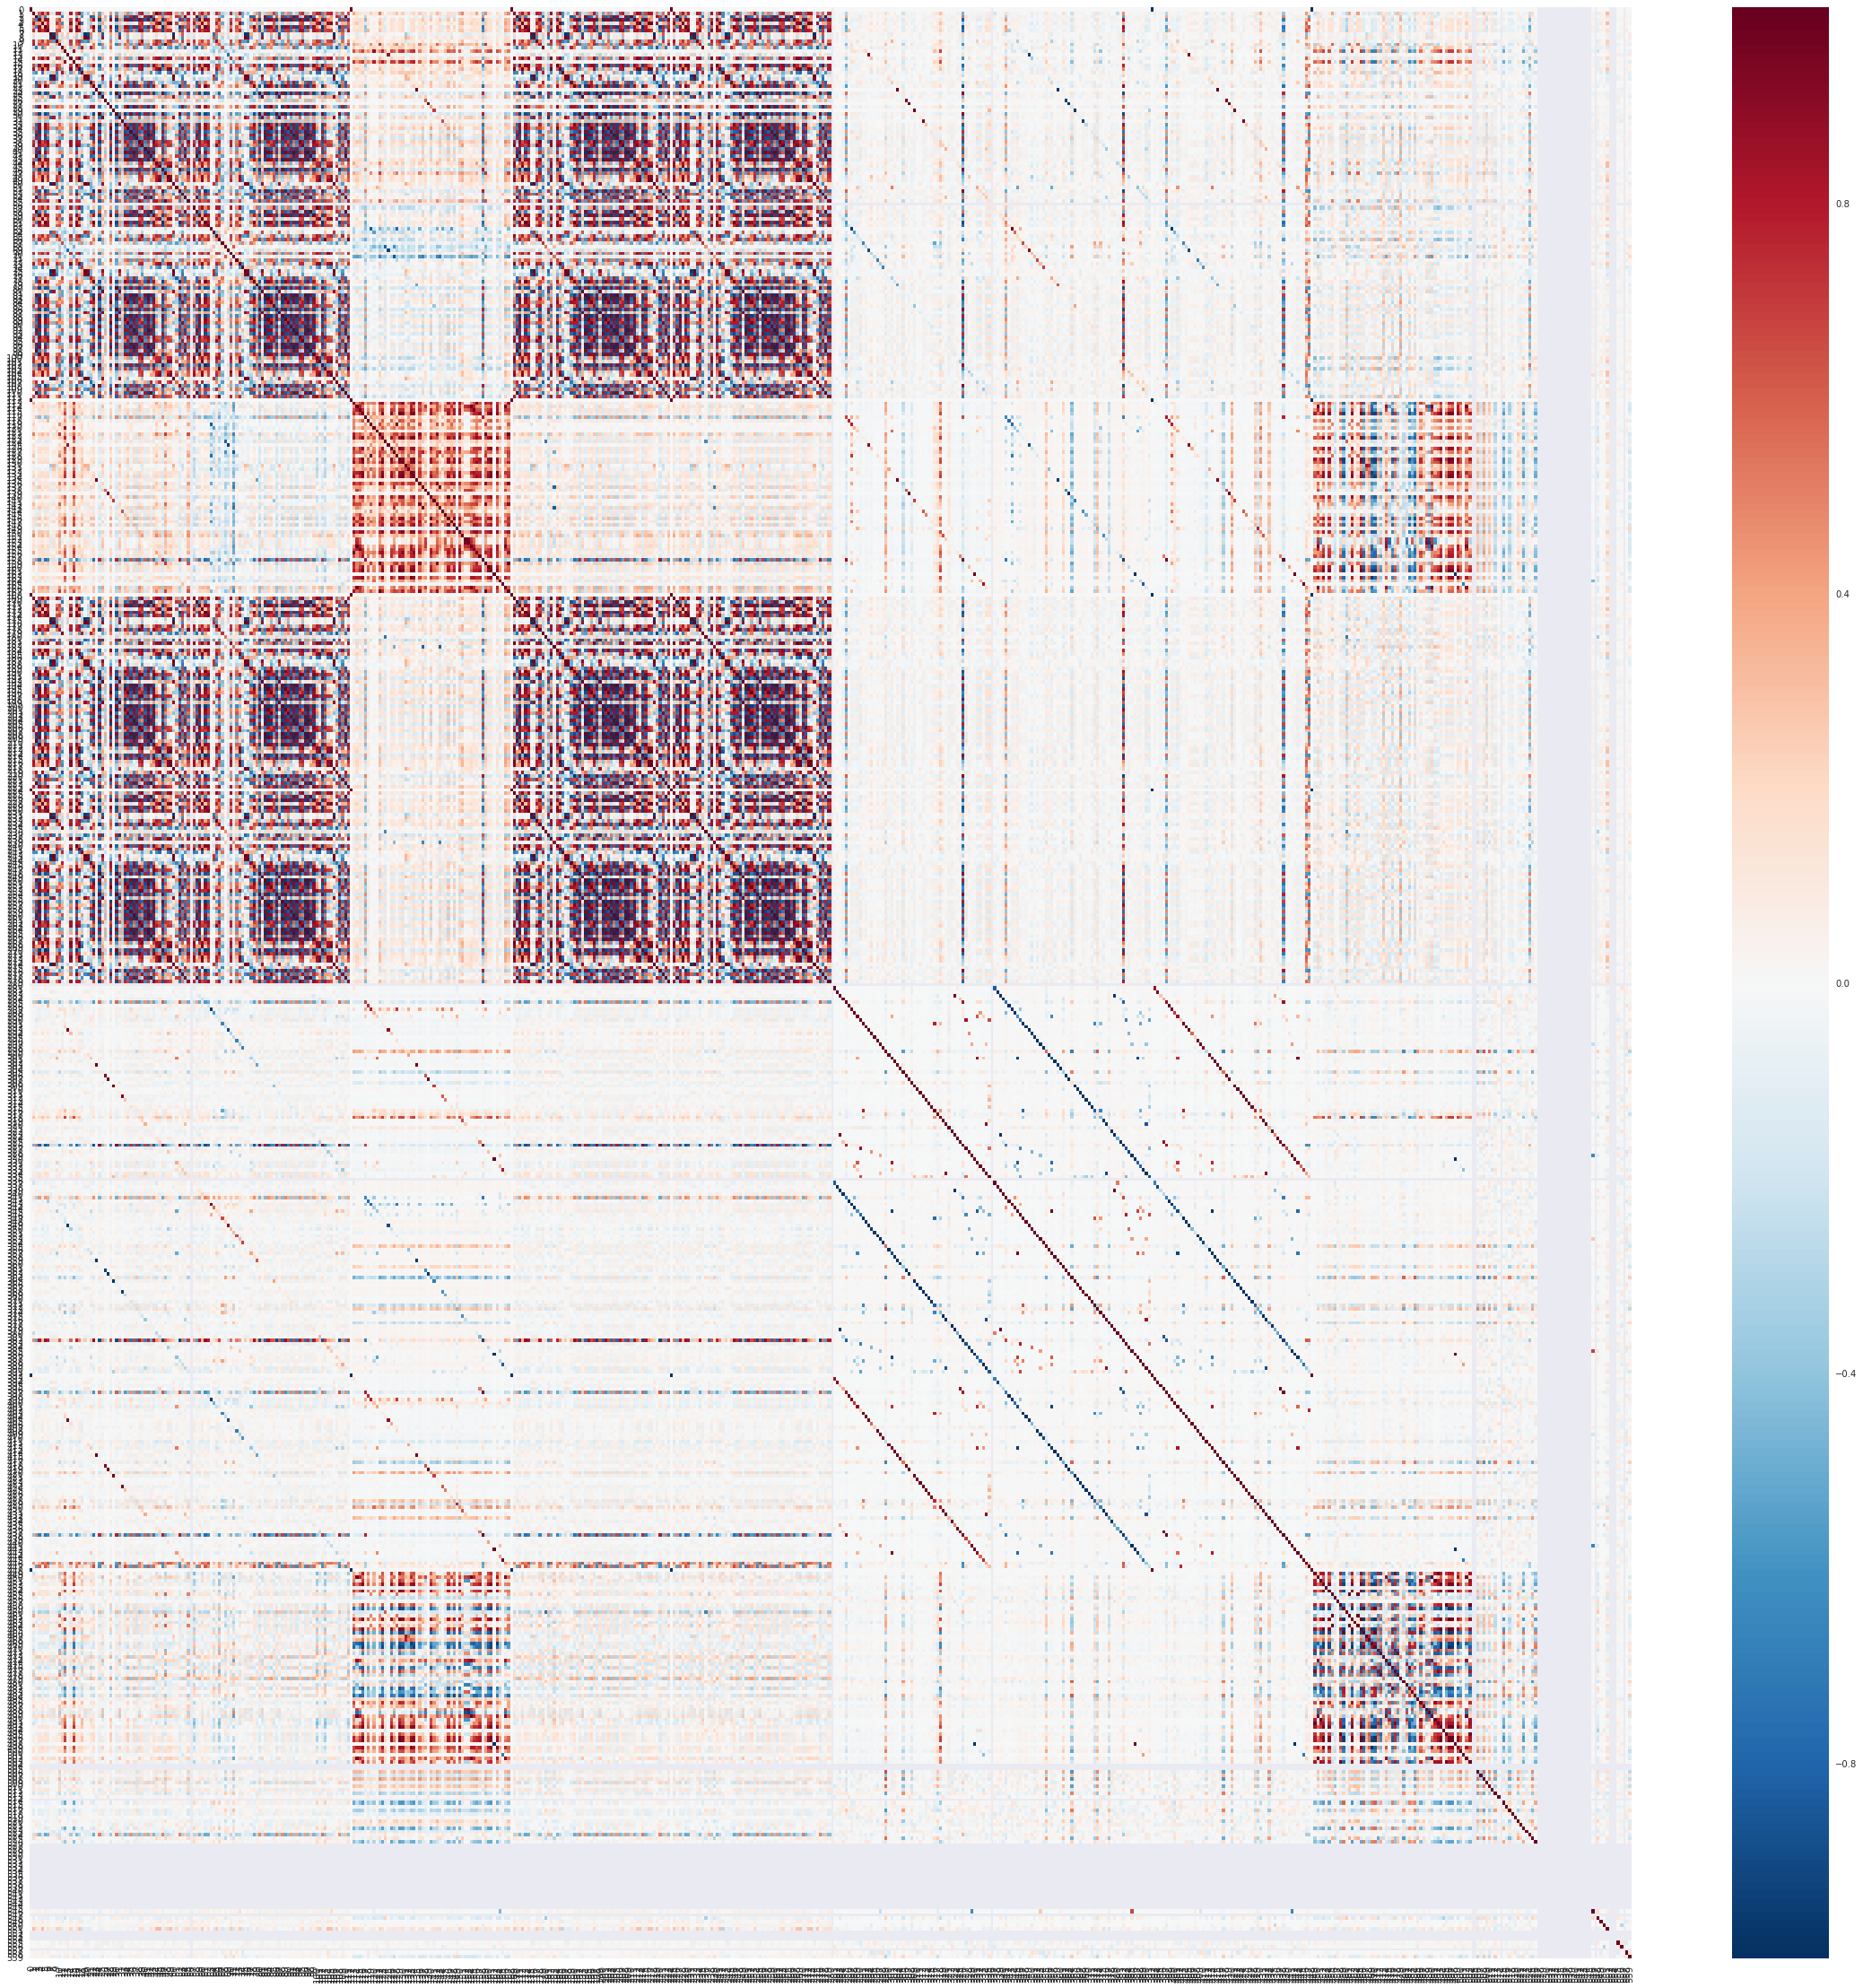

In [50]:
# plt.figure(figsize=(40,40))
# sns.heatmap(X.corr())

# XGB

In [44]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['max_depth'] = 7
# param['booster'] = 'gbtree'
param['booster'] = 'gblinear'
param['eta'] = 0.01
# param['subsample'] = 0.9
# param["scale_pos_weight"] = 0.5
param['colsample_bytree'] = 0.1
param['nthread'] = 8
param['alpha'] = 0.00
param['lambda_bias'] = 0.1
# param['min_child_weight'] = 5

# if param['booster'] == 'gblinear': param['eta'] *= 1e-4
numround = 15001
# scores, , []

skf = StratifiedKFold(5, shuffle=True, random_state=0)
sc,sc2 = [],[]
pred_train1 = np.zeros(len(y))
pred_train2 = np.zeros(len(y))

xgbs = []
ets = []

for itr, ite in skf.split(y[y['train'] == 1]['SeriesId'].values, y[y['train'] == 1]['Attack'].values):

    ypred,ypred2 = [],[]
    for i in range(1):
        param['seed'] = i+1

        #xgboost
        Xdatatrain = xgboost.DMatrix(data=X.iloc[itr].values,
                                     label=y.iloc[itr]['Attack'].values)
        Xdataval = xgboost.DMatrix(data=X.iloc[ite].values,
                                    label=y.iloc[ite]['Attack'].values)

        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdataval, 'eval')]
        bst = xgboost.train(plst, Xdatatrain, 100000, evals=watchlist, verbose_eval=1000, 
                            early_stopping_rounds=int(5 / param['eta'] ** 0.5))

        ypred.append(bst.predict(Xdataval))
        xgbs.append(bst)
        
        # extra trees
        clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=16, criterion='entropy',
                                  max_features=0.1, min_samples_split=10)
        clf.fit(X.iloc[itr].values,y.iloc[itr]['Attack'].values)
        ypred2.append(clf.predict_proba(X.iloc[ite].values)[:,1])
        ets.append(clf)
        
    ypred = sum(ypred) / len(ypred)
    ypred2 = sum(ypred2) / len(ypred2)
    pred_train1[ite] = ypred
    pred_train2[ite] = ypred2
    
    sc.append(auc(y.iloc[ite]['Attack'].values, ypred))
    sc2.append(auc(y.iloc[ite]['Attack'].values, ypred2))
#     break

print( 'XGB: {:.3f} +- {:.3f}'.format(np.mean(sc), np.std(sc)))
print('ET: {:.3f} +- {:.3f}'.format(np.mean(sc2), np.std(sc2)))

[0]	train-auc:0.857679	eval-auc:0.750322
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[500]	train-auc:0.992653	eval-auc:0.972115

[0]	train-auc:0.859636	eval-auc:0.766624
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[161]	train-auc:0.981312	eval-auc:0.893608

[0]	train-auc:0.864624	eval-auc:0.748606
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[267]	train-auc:0.985173	eval-auc:0.962248

[0]	train-auc:0.849287	eval-auc:0.77263
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[264]	train-auc:0.987103	eval-auc:0.9

##### top score (yet)
    XGB: 0.928 +- 0.021
    ET: 0.937 +- 0.018

# PLOTTING

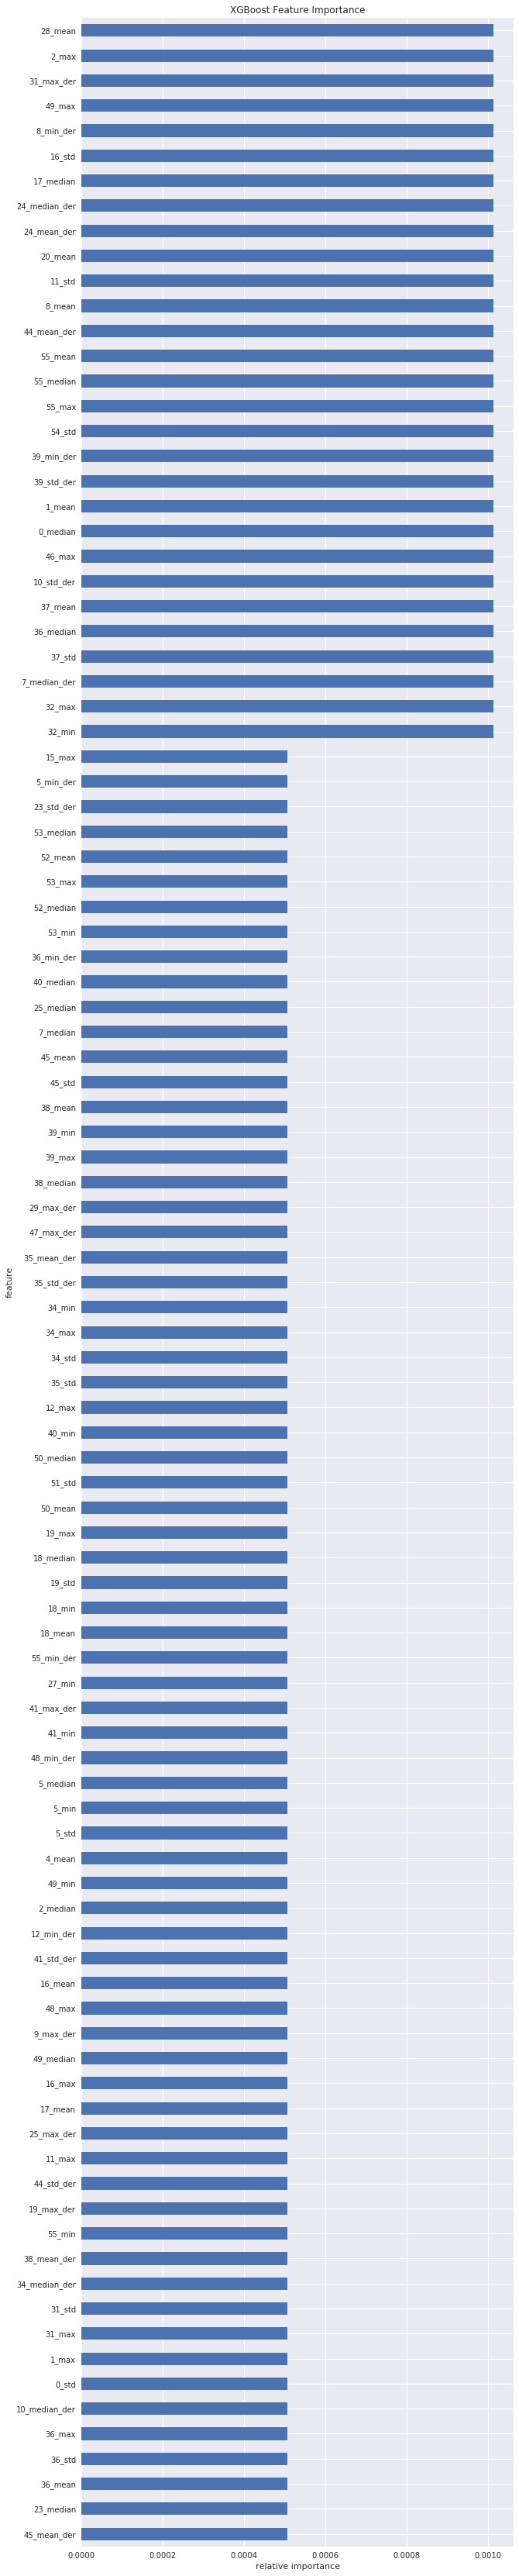

In [53]:
###### plot 
import operator
importance = xgbs[0].get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df.feature = [fnames[int(item[1:])] for item in df.feature]
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.loc[:100]
plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10,60))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [ ]:
# sns.regplot(pred_train1, pred_train2)

# XGB PREDICT

In [59]:
# predictions name
pred_name = "der_tuned"

In [49]:
subm = pd.read_csv('./sample_submission.csv')

In [56]:
len(lstm_test_files)

500

In [58]:
files = ['/mnt/kaspersky/data_kasp/test/'+f for f in subm.SeriesId][:]
lstm_test_files = ['tmp/lstmfeats/'+f.replace("train", "test")+".npy" for f in data.SeriesIdnpy][:]

print(lstm_test_files[0])


pool = Pool(16)
X_test = None
try: X_test = pd.DataFrame(pool.map(calc_feats, zip(files, lstm_test_files)))
except ValueError as error: print(error)
pool.terminate()
X_test.fillna(-999, inplace=True)
y_test = subm.copy()[:len(X_test)]
print X_test.shape

tmp/lstmfeats/0_test.npy
(500, 1060)


# XGB predictions

In [8]:
X_test.columns = ["f%d" % item for item in X_test.columns]
Xdatatrain = xgboost.DMatrix(data=X_test)

In [9]:
preds = []
for model in xgbs:
    preds.append(model.predict(Xdatatrain))
mean_preds = sum(preds) / len(preds)

In [10]:
# !mkdir submissions
subm.Attack = 1-mean_preds
subm.Attack = subm.Attack.map(lambda x: np.round(x, 3))
subm.to_csv("./submissions/xgb_window_100.csv", index=False)

# Extra trees predictions

In [59]:
preds_et = []
for model in ets:
    preds_et.append(model.predict_proba(X_test))
mean_preds_et = sum(preds_et) / len(preds_et)

In [60]:
subm.Attack = mean_preds_et[:,1] 
subm.Attack = subm.Attack.map(lambda x: np.round(x, 3))
subm.to_csv("./submissions/et_window_250_lstm.csv", index=False)